# Pipeline to evaluate calibration methods

In order to compare several calibration methods we will use 

- Select D datasets
- Select C base classifiers
- Select M calibration methods

The M calibration methods will be compared in all DxC combinations

For each pair (M, DxC) we will run several evaluations in order to get better estimates. To do that we will

- Repeat N times the following process:
- 5-fold cross-validation to divide the random shuffle into train and test
- The train partition will be further divided with 3-fold cross-validation to train and validate the classifier + calibrator combination

The previous process will generate Nx5 evaluation estimations

Finally, the M calibrators with the Nx5 estimations for each DxC combination are compared in the following manner.

1. We rank the M calibrators and perform a Friedman test to get the statistical difference.
2. If the p-value of the test is under 0.005 we performed a post-hoc one-tailed Bonferroni-Dunn test to obtain Critical Differences which indicate the minimum ranking difference to consider the methods significantly different.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycalib.stats import compute_friedmanchisquare, plot_critical_difference
from pycalib.utils import plot_df_to_heatmap
from scipy.stats import rankdata

df_results = pd.read_csv('data/results.csv.zip')

In [2]:
category_list = ['dataset', 'method', 'classifier']
for cat in category_list:
    df_results[cat] = df_results[cat].astype('category')

df_results.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'dataset', 'n_classes', 'n_features',
       'n_samples', 'method', 'mc', 'test_fold', 'train_acc', 'train_loss',
       'train_brier', 'acc', 'loss', 'brier', 'calibrators', 'classifier'],
      dtype='object')

In [3]:
n_datasets = len(df_results['dataset'].cat.categories)
n_classifiers = len(df_results['classifier'].cat.categories)
n_calibrators = len(df_results['method'].cat.categories)
print('Datasets: {}\nClassifiers: {}\nCalibrators: {}'.format(
            n_datasets, n_classifiers, n_calibrators))

Datasets: 21
Classifiers: 11
Calibrators: 9


# Selecting an evaluation metric

For the following examples we will focus on Brier score as an evaluation measure. If 

In [4]:
measure = 'brier'
max_is_better = False

# Example for one classifier

Here we perform a statistical test focusing only in one classifier, and comparing all the calibration methods with several datasets.

### Friedman test

First we compute the Friedman test to find if there are significant differences between the calibration methods.

In [5]:
classifier_name = 'logistic'

class_mask = df_results['classifier'] == classifier_name
table = df_results[class_mask].pivot_table(index=['dataset'],
                                   columns=['method'],
                                   values=[measure],
                                   aggfunc=np.mean)

# Perform a Friedman statistic test
# Remove datasets in which one of the experiments failed
table = table[~table.isna().any(axis=1)]
if max_is_better:
    table *= -1

ftest = compute_friedmanchisquare(table)
print(ftest)

FriedmanchisquareResult(statistic=111.5936507936508, pvalue=1.79050686771319e-20)


### One-tailed Bonferroni-Dunn test (or Nemenyi test)

The average rankings are then compared with a One-tailed Bonferroni-Dunn test. However, if the number of compared calibrators is larger than 10, the Nemenyi test is used instead.

Critical Difference computed with avranks of shape (9,) for 21 datasets


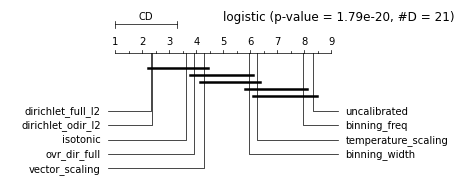

In [6]:
ranking_table = table.apply(rankdata, axis=1).mean()
print(('Critical Difference computed with avranks of shape {} ' +
       'for {} datasets').format(np.shape(ranking_table),
                             table.shape[0]))
_ = plot_critical_difference(avranks=ranking_table,
                           num_datasets=table.shape[0],
                           names=table.columns.levels[1],
                           title='{} (p-value = {:.2e}, #D = {})'.format(classifier_name, 
                                                                        ftest.pvalue, table.shape[0]))

# Datasets and classifiers combinations

Finally, we perform the final analysis with all the classifiers and datasets combined.

Friedman test on the full table of shape (229, 9)
FriedmanchisquareResult(statistic=645.5841915644676, pvalue=3.6798823197721567e-134)
Critical Difference computed with avranks of shape (229, 9) for 229 dataset and classifier combinations


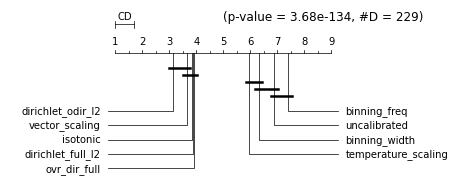

In [7]:
## --------------------------------------------------------------##
## Aggregated rankings
# Perform rankings of dataset+classifier vs calibration method
table = df_results.pivot_table(index=['dataset', 'classifier'],
                       columns=['method'],
                       values=[measure], aggfunc=np.mean)
#table = table.reindex(new_order, axis=1, level='method')
#table.sort_index(inplace=True)
# Remove datasets and classifier combinations in which one of the experiments failed
table = table[~table.isna().any(axis=1)]
if max_is_better:
    table *= -1
ranking_table_all = table.apply(rankdata, axis=1).mean()
ftest = compute_friedmanchisquare(table)
print('Friedman test on the full table of shape {}'.format(
            np.shape(table)))
print(ftest)
print(('Critical Difference computed with avranks of shape {} for ' +
       '{} dataset and classifier combinations').format(np.shape(table),
                             len(table)))
_ = plot_critical_difference(avranks=ranking_table_all,
                           num_datasets=len(table),
                           names=table.columns.levels[1],
                           title='(p-value = {:.2e}, #D = {})'.format(ftest.pvalue, len(table)))
